# Daily Weather Processing 

This notebook pulls daily weather data for each county, using the geocoordinates of the centroid of the county. We will pull data to match with our Medicare records: July 1st 2009 - October 1st 2015. 


In [2]:
!pip install meteostat

In [142]:
from datetime import datetime
from meteostat import Point, Daily, Stations
import pandas as pd
import numpy as np
import matplotlib as plt
import geopandas as gpd
import geoplot as gplt
import time

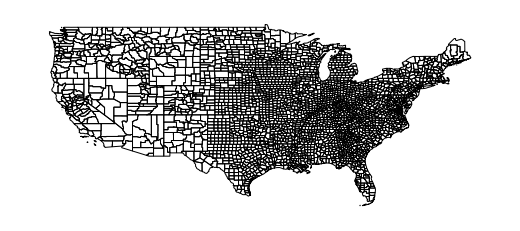

In [239]:
#get the centroids from each county 

# plotting 
#https://python-graph-gallery.com/choropleth-map-geopandas-python

# Load the json file with county coordinates
US_counties = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
US_counties.id = US_counties.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
US_counties = US_counties[~US_counties.STATE.isin(stateToRemove)]

US_counties.reset_index(inplace = True, drop = True)

# Basic plot with just county outlines
gplt.polyplot(US_counties, figsize=(20, 4));

In [189]:
US_counties.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,1001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402..."
1,1009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840..."
2,1017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772..."
3,1021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929..."
4,1033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587..."


In [192]:
len(US_counties)

3109

In [190]:
US_counties_ID = list(US_counties['id'].unique())

In [191]:
len(US_counties_ID)

3109

In [147]:
medicare_df = pd.read_csv("medicare_monthly_falls.csv")

In [148]:
medicare_df.head()

,month_count,fipscounty,date
0,NaN,1001,2010-01
1,14.0,1001,2011-01
2,NaN,1001,2012-01
3,NaN,1001,2013-01
4,NaN,1001,2014-01


In [149]:
medicare_counties = list(medicare_df['fipscounty'].unique())

In [150]:
len(medicare_counties)

3107

In [151]:
missing_counties = []

for m in medicare_counties: 
    if m not in US_counties_ID: 
        missing_counties.append(m)

In [152]:
len(missing_counties)

0

In [175]:
for c in US_counties_ID: 
    if c not in medicare_counties: 
        print(c)

48301
48269


In [100]:
#most of these are statewide counties which we don't want/need
#missing_counties

In [193]:
#reproject to CRS of latitude and longitude 
US_counties = US_counties.to_crs("EPSG:4326")

In [338]:
#find centroids lat and longitude 
#already reprojected
#https://gis.stackexchange.com/questions/412817/how-to-get-lat-and-lon-from-a-geopandas-geodataframe-polygon
US_counties['lon'] = US_counties.centroid.x  
US_counties['lat'] = US_counties.centroid.y

In [339]:
US_counties.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,Station_ID,lon,lat
0,1001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",KMXF0,-86.641196,32.536153
1,1009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",K8A00,-86.569756,33.985248
2,1017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772...",KLGC0,-85.389924,32.911594
3,1021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",72230,-86.719793,32.850253
4,1033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587...",KMSL0,-87.805890,34.701644


In [156]:
# set up for iteration
FIPS_list = list(US_counties['id'])
lat_list = list(US_counties['lat'])
lon_list = list(US_counties['lon'])

#meteostat object of all stations
stations = Stations()

In [157]:
len(FIPS_list)
#3,109 counties in the contiguous US 

3109

In [230]:
FIPS_list[24]

8013

In [ ]:
#https://meteostat.net/en/

In [345]:
#Grab from closest station with complete data 

ID_list_complete = []

start = pd.Timestamp('2009-07-01 00:00:00')
end = pd.Timestamp('2009-07-01 00:00:00')

for c in range(len(FIPS_list)):
    
    station_query = stations.nearby(lat = lat_list[c], lon = lon_list[c])
    station_df = station_query.fetch(5)
    
    for r in range(len(station_df)):
        if station_df.iloc[r, 11] <= start and station_df.iloc[r, 12] >= end:
            station_id = station_df.index[r]
            ID_list_complete.append([FIPS_list[c], station_id])
            break
        
        #if it reaches the end and there's no weather station with complete data for the full period 
        #just choose the closest weather station and grab whatever data they have
        if r == len(station_df)-1:
            print("last one", FIPS_list[c])
            ID_list_complete.append([FIPS_list[c], station_df.index[0]])
            

last one 8013
last one 8047
last one 47005
last one 47031
last one 47081
last one 47117
last one 47101
last one 47119
last one 47135
last one 38005
last one 38063
last one 47003
last one 38071
last one 47177
last one 37087
last one 48015
last one 47085
last one 47127
last one 13315
last one 47183
last one 38099
last one 47079
last one 56001


In [346]:
len(ID_list_complete)

3109

In [347]:
updated_FIPS_IDs = pd.DataFrame(ID_list_complete, columns = ['FIPS', 'Station_ID'])

In [348]:
updated_FIPS_IDs.head()

,FIPS,Station_ID
0,1001,KMXF0
1,1009,K8A00
2,1017,KLGC0
3,1021,72230
4,1033,KMSL0


In [349]:
#unique stations? 
len(updated_FIPS_IDs['Station_ID'].unique())


1352

In [350]:
US_counties.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,Station_ID,lon,lat
0,1001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",KMXF0,-86.641196,32.536153
1,1009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",K8A00,-86.569756,33.985248
2,1017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772...",KLGC0,-85.389924,32.911594
3,1021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",72230,-86.719793,32.850253
4,1033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587...",KMSL0,-87.805890,34.701644


In [351]:
counties_stations = US_counties.merge(updated_FIPS_IDs, left_on='id', right_on='FIPS', how = 'inner')

In [352]:
counties_stations.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,Station_ID_x,lon,lat,FIPS,Station_ID_y
0,1001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",KMXF0,-86.641196,32.536153,1001,KMXF0
1,1009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",K8A00,-86.569756,33.985248,1009,K8A00
2,1017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772...",KLGC0,-85.389924,32.911594,1017,KLGC0
3,1021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",72230,-86.719793,32.850253,1021,72230
4,1033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587...",KMSL0,-87.805890,34.701644,1033,KMSL0


In [353]:
len(counties_stations['id'].unique())


3109

In [354]:
#any missing stations? 
counties_stations.isnull().sum()

id              0
GEO_ID          0
STATE           0
COUNTY          0
NAME            0
LSAD            0
CENSUSAREA      0
geometry        0
Station_ID_x    0
lon             0
lat             0
FIPS            0
Station_ID_y    0
dtype: int64

In [359]:
#QUERY 

unique_stations = list(counties_stations['Station_ID_y'].unique())


In [360]:
# Set time period
start = datetime(2009, 7, 1)
end = datetime(2015, 10, 1)

updated_df_list = []

for i in range(len(unique_stations)):
    
    # Get daily data
    data = Daily(unique_stations[i], start, end)
    data = data.fetch()
    data['station_id'] = unique_stations[i]
    data = data.reset_index(drop=False, inplace=False)
    updated_df_list.append(data)

updated_weather_data = pd.concat(updated_df_list)

In [362]:
updated_weather_data.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id
0,2009-07-01,28.4,19.4,36.1,NaN,NaN,NaN,4.5,NaN,1008.7,NaN,KMXF0
1,2009-07-02,28.5,22.4,35.0,NaN,NaN,NaN,5.4,NaN,1012.9,NaN,KMXF0
2,2009-07-03,27.7,21.4,34.7,NaN,NaN,NaN,6.8,NaN,1016.9,NaN,KMXF0
3,2009-07-04,27.9,19.3,34.9,NaN,NaN,NaN,3.0,NaN,1016.3,NaN,KMXF0
4,2009-07-05,27.9,23.0,35.2,NaN,NaN,NaN,6.9,NaN,1012.2,NaN,KMXF0


In [363]:
updated_full_FIPS = updated_FIPS_IDs.merge(updated_weather_data, left_on='Station_ID', right_on='station_id', how = 'left')

In [364]:
updated_full_FIPS.head()

,FIPS,Station_ID,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id
0,1001,KMXF0,2009-07-01,28.4,19.4,36.1,NaN,NaN,NaN,4.5,NaN,1008.7,NaN,KMXF0
1,1001,KMXF0,2009-07-02,28.5,22.4,35.0,NaN,NaN,NaN,5.4,NaN,1012.9,NaN,KMXF0
2,1001,KMXF0,2009-07-03,27.7,21.4,34.7,NaN,NaN,NaN,6.8,NaN,1016.9,NaN,KMXF0
3,1001,KMXF0,2009-07-04,27.9,19.3,34.9,NaN,NaN,NaN,3.0,NaN,1016.3,NaN,KMXF0
4,1001,KMXF0,2009-07-05,27.9,23.0,35.2,NaN,NaN,NaN,6.9,NaN,1012.2,NaN,KMXF0


In [365]:
len(updated_full_FIPS['FIPS'].unique())

3109

In [366]:
updated_full_FIPS.isnull().sum()

FIPS                0
Station_ID          0
time               50
tavg           255340
tmin            17843
tmax            17977
prcp          2968495
snow          4923523
wdir          4748017
wspd           287545
wpgt          6060802
pres          2928959
tsun          6048580
station_id         50
dtype: int64

In [383]:
len(updated_full_FIPS['Station_ID'].unique())

1352

In [371]:
updated_full_FIPS.to_csv("updated_daily_weather_station_data.csv")

In [384]:
#there are 50 counties missing data... 
updated_full_FIPS[updated_full_FIPS['station_id'].isnull()]

,FIPS,Station_ID,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id
123594,12055,KSEF0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205447,18079,72436,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421499,21143,KTWT0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887393,36043,74480,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
934260,47005,KHZD0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940162,47031,KAYX0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945656,47081,KM020,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950225,47117,KLUG0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258562,51007,KBKT0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1270938,51111,KBKT0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [390]:
#let's grab these and just find the nearest station that returns any data 
missing_counties = updated_full_FIPS[updated_full_FIPS['station_id'].isnull()]

In [391]:
missing_counties.head()

,FIPS,Station_ID,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id
123594,12055,KSEF0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205447,18079,72436,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421499,21143,KTWT0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887393,36043,74480,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
934260,47005,KHZD0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [392]:
missing_counties = list(missing_counties['FIPS'])

In [400]:
#create new lists of counties and their lon/lat
US_missing = US_counties[US_counties['id'].isin(missing_counties)]

In [401]:
US_missing.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,Station_ID,lon,lat
62,12055,0500000US12055,12,055,Highlands,County,1016.615,"POLYGON ((-80.94319 27.21060, -81.16914 27.209...",KSEF0,-81.344920,27.342069
102,18079,0500000US18079,18,079,Jennings,County,376.583,"POLYGON ((-85.68384 38.81541, -85.79536 38.807...",KIMS0,-85.626247,38.994240
210,21143,0500000US21143,21,143,Lyon,County,213.840,"POLYGON ((-88.09578 37.17968, -88.04214 37.174...",KCEY0,-88.082954,37.023462
438,36043,0500000US36043,36,043,Herkimer,County,1411.470,"POLYGON ((-75.21216 42.87997, -75.21911 43.052...",KUCA0,-74.962181,43.420459
462,47005,0500000US47005,47,005,Benton,County,394.142,"POLYGON ((-87.98074 36.35331, -87.94960 36.243...",KHZD0,-88.070354,36.063916


In [409]:
len(missing_counties)

50

In [402]:
missing_lon = list(US_missing['lon'])
missing_lat = list(US_missing['lat'])

In [403]:
start = datetime(2009, 7, 1)
end = datetime(2015, 10, 1)

In [422]:
missing_df_list = []

for i in range(len(missing_counties)): 
    
    station_query = stations.nearby(lat = missing_lat[i], lon = missing_lon[i])
    station_df = station_query.fetch(5)
    
    for r in range(len(station_df)):
        
        if station_df.iloc[r, 11] <= start and station_df.iloc[r, 12] >= end:
            station_id = station_df.index[r]
            
            data = Daily(station_id, start, end)
            data = data.fetch()
            
            if len(data) > 0 :
                data['FIPS'] = missing_counties[i]
                data['station_id'] = station_id
                data = data.reset_index(drop=False, inplace=False)
                missing_df_list.append(data)
                break
        
        #if it reaches the end and there's no weather station with complete data for the full period 
        #just choose the closest weather station and grab whatever data they have
        if r == len(station_df)-1:
            print("last one", missing_counties[i])
            
            #this is a little janky but whatever 
            for s in range(len(station_df)):
                station_id = station_df.index[s]

                data = Daily(station_id, start, end)
                data = data.fetch()

                if len(data) > 0 :
                    data['FIPS'] = missing_counties[i]
                    data['station_id'] = station_id
                    data = data.reset_index(drop=False, inplace=False)
                    missing_df_list.append(data)
                    break
                
                        

last one 47005
last one 47031
last one 47081
last one 47117
last one 47135
last one 47003
last one 47177
last one 48015
last one 47085
last one 13315
last one 56001


In [423]:
missing_weather_data = pd.concat(missing_df_list)

In [426]:
missing_weather_data.tail()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,FIPS,station_id
508,2015-09-27,19.2,10.5,29.3,NaN,NaN,300.0,11.5,NaN,1009.5,NaN,56001,KFEW0
509,2015-09-28,14.7,8.6,20.3,NaN,NaN,1.0,13.0,NaN,1012.0,NaN,56001,KFEW0
510,2015-09-29,13.5,9.1,19.2,NaN,NaN,203.0,17.4,NaN,NaN,NaN,56001,KFEW0
511,2015-09-30,14.3,5.3,24.0,NaN,NaN,294.0,10.1,NaN,1016.9,NaN,56001,KFEW0
512,2015-10-01,15.8,7.2,25.2,NaN,NaN,198.0,8.2,NaN,1017.3,NaN,56001,KFEW0


In [425]:
len(missing_weather_data['FIPS'].unique())

50

In [427]:
#save this 
missing_weather_data.to_csv("missing_stations_data.csv")

In [428]:
updated_full_FIPS.head()

,FIPS,Station_ID,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id
0,1001,KMXF0,2009-07-01,28.4,19.4,36.1,NaN,NaN,NaN,4.5,NaN,1008.7,NaN,KMXF0
1,1001,KMXF0,2009-07-02,28.5,22.4,35.0,NaN,NaN,NaN,5.4,NaN,1012.9,NaN,KMXF0
2,1001,KMXF0,2009-07-03,27.7,21.4,34.7,NaN,NaN,NaN,6.8,NaN,1016.9,NaN,KMXF0
3,1001,KMXF0,2009-07-04,27.9,19.3,34.9,NaN,NaN,NaN,3.0,NaN,1016.3,NaN,KMXF0
4,1001,KMXF0,2009-07-05,27.9,23.0,35.2,NaN,NaN,NaN,6.9,NaN,1012.2,NaN,KMXF0


In [434]:
#cut down so can just concatenate dfs together 
small_full = updated_full_FIPS[~updated_full_FIPS['station_id'].isnull()]

In [435]:
small_full.isnull().sum()

FIPS                0
Station_ID          0
time                0
tavg           255290
tmin            17793
tmax            17927
prcp          2968445
snow          4923473
wdir          4747967
wspd           287495
wpgt          6060752
pres          2928909
tsun          6048530
station_id          0
dtype: int64

In [436]:
len(small_full['FIPS'].unique())
#good! 50 short 

3059

In [440]:
small_full.drop(['Station_ID'], axis=1, inplace = True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [441]:
small_full.head()

,FIPS,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id
0,1001,2009-07-01,28.4,19.4,36.1,NaN,NaN,NaN,4.5,NaN,1008.7,NaN,KMXF0
1,1001,2009-07-02,28.5,22.4,35.0,NaN,NaN,NaN,5.4,NaN,1012.9,NaN,KMXF0
2,1001,2009-07-03,27.7,21.4,34.7,NaN,NaN,NaN,6.8,NaN,1016.9,NaN,KMXF0
3,1001,2009-07-04,27.9,19.3,34.9,NaN,NaN,NaN,3.0,NaN,1016.3,NaN,KMXF0
4,1001,2009-07-05,27.9,23.0,35.2,NaN,NaN,NaN,6.9,NaN,1012.2,NaN,KMXF0


In [442]:
#concatenate together
real_full_FIPS = pd.concat([missing_weather_data, small_full], ignore_index=True)

In [444]:
real_full_FIPS.tail()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,FIPS,station_id
6145299,2015-09-26,19.3,18.0,21.1,NaN,NaN,31.0,16.7,NaN,NaN,NaN,51041,KPTB0
6145300,2015-09-27,21.2,17.6,24.8,NaN,NaN,37.0,17.9,NaN,NaN,NaN,51041,KPTB0
6145301,2015-09-28,23.9,21.5,27.4,NaN,NaN,54.0,11.7,NaN,NaN,NaN,51041,KPTB0
6145302,2015-09-30,25.1,21.5,30.2,NaN,NaN,NaN,9.4,NaN,NaN,NaN,51041,KPTB0
6145303,2015-10-01,16.7,14.6,21.1,NaN,NaN,6.0,18.4,NaN,NaN,NaN,51041,KPTB0


In [445]:
len(real_full_FIPS['FIPS'].unique())
#yay! all counties

3109

In [446]:
real_full_FIPS.isnull().sum()

time                0
tavg           259768
tmin            18088
tmax            18191
prcp          3016539
snow          4995189
wdir          4814438
wspd           293975
wpgt          6143699
pres          2976187
tsun          6131283
FIPS                0
station_id          0
dtype: int64

In [447]:
real_full_FIPS.to_csv("complete_daily_weather_station_data.csv")

In [448]:
#pickle this too 
real_full_FIPS.to_pickle("complete_daily_weather.pkl")

## Aggregation

Now we'll aggregate the data to the monthly level where we will want the min, max, mean, median, and standard deviation of each of the variables. 

In [449]:
#create year-month key 
real_full_FIPS['month_year'] = pd.to_datetime(real_full_FIPS['time']).dt.to_period('M')

In [451]:
real_full_FIPS.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,FIPS,station_id,month_year
0,2009-07-01,27.0,23.0,31.7,NaN,NaN,219.0,15.4,NaN,NaN,NaN,12055,KPGD0,2009-07
1,2009-07-02,27.2,24.4,31.7,NaN,NaN,NaN,13.5,NaN,1016.7,NaN,12055,KPGD0,2009-07
2,2009-07-03,28.1,25.0,31.7,NaN,NaN,NaN,10.8,NaN,1018.7,NaN,12055,KPGD0,2009-07
3,2009-07-04,28.5,25.0,32.8,NaN,NaN,NaN,6.2,NaN,1017.6,NaN,12055,KPGD0,2009-07
4,2009-07-05,28.8,25.0,32.2,0.0,NaN,NaN,10.1,NaN,1016.6,NaN,12055,KPGD0,2009-07


In [452]:
real_full_FIPS.drop(['station_id'], axis = 1, inplace = True)

In [453]:
len(real_full_FIPS['FIPS'].unique())

3109

In [454]:
#groupby county, month_year and create summary statistics 

monthly_summaries = real_full_FIPS.groupby(["FIPS", "month_year"]).agg(
        {
    "tavg": ["min", "max", "median", "mean", "std"],
    "tmin": ["min", "max", "median", "mean", "std"],
    "tmax": ["min", "max", "median", "mean", "std"],
    "prcp": ["min", "max", "median", "mean", "std"],
    "snow": ["min", "max", "median", "mean", "std"],
    "wdir": ["min", "max", "median", "mean", "std"], 
    "wspd": ["min", "max", "median", "mean", "std"],
    "wpgt": ["min", "max", "median", "mean", "std"],
    "pres": ["min", "max", "median", "mean", "std"],
    "tsun": ["min", "max", "median", "mean", "std"]
        })


In [455]:
monthly_summaries.head()

tavg                                    tmin               \
                  min   max median       mean       std   min   max median   
FIPS month_year                                                              
1001 2009-07     23.0  28.7   26.4  26.306897  1.427018  16.2  24.5   22.0   
     2009-08     21.9  28.6   26.2  26.096552  1.591604  15.8  24.1   22.7   
     2009-09     17.4  26.4   24.6  24.158621  2.024408  11.2  23.1   22.0   
     2009-10      8.9  26.5   19.3  18.162069  4.860586   3.8  22.1   14.7   
     2009-11      6.7  18.1   12.2  12.196552  2.732278   0.9  16.0    6.5   

                                      ...    pres                   \
                      mean       std  ...     min     max   median   
FIPS month_year                       ...                            
1001 2009-07     21.589655  1.979420  ...  1008.7  1022.0  1016.30   
     2009-08     21.968966  2.047316  ...  1012.2  1021.6  1016.85   
     2009-09     21.065517  2.840432  ...  1011.9  1018.8  1016.75   
     2009-10     13.748276  5.431563  ...  1008.3  1025.8  1015.85   
     2009-11      6.644828  3.788477  ...  1011.7  1026.8  1019.90   

                                       tsun                      
                        mean       std  min max median mean std  
FIPS month_year                                                  
1001 2009-07     1016.054167  2.961342  NaN NaN    NaN  NaN NaN  
     2009-08     1017.096429  2.036788  NaN NaN    NaN  NaN NaN  
     2009-09     1015.935714  2.193292  NaN NaN    NaN  NaN NaN  
     2009-10     1016.707143  4.409244  NaN NaN    NaN  NaN NaN  
     2009-11     1019.275000  3.990881  NaN NaN    NaN  NaN NaN  

[5 rows x 50 columns]

In [456]:
#rename columns
monthly_summaries.columns = ["tavg_min", "tavg_max", "tavg_median", "tavg_mean", "tavg_std",
    "tmin_min", "tmin_max", "tmin_median", "tmin_mean", "tmin_std",
    "tmax_min", "tmax_max", "tmax_median", "tmax_mean", "tmax_std",
    "prcp_min", "prcp_max", "prcp_median", "prcp_mean", "prcp_std",
    "snow_min", "snow_max", "snow_median", "snow_mean", "snow_std",
    "wdir_min", "wdir_max", "wdir_median", "wdir_mean", "wdir_std", 
    "wspd_min", "wspd_max", "wspd_median", "wspd_mean", "wspd_std",
    "wpgt_min", "wpgt_max", "wpgt_median", "wpgt_mean", "wpgt_std",
    "pres_min", "pres_max", "pres_median", "pres_mean", "pres_std",
    "tsun_min", "tsun_max", "tsun_median", "tsun_mean", "tsun_std"]

In [457]:
monthly_summaries.head()

tavg_min  tavg_max  tavg_median  tavg_mean  tavg_std  \
FIPS month_year                                                         
1001 2009-07         23.0      28.7         26.4  26.306897  1.427018   
     2009-08         21.9      28.6         26.2  26.096552  1.591604   
     2009-09         17.4      26.4         24.6  24.158621  2.024408   
     2009-10          8.9      26.5         19.3  18.162069  4.860586   
     2009-11          6.7      18.1         12.2  12.196552  2.732278   

                 tmin_min  tmin_max  tmin_median  tmin_mean  tmin_std  ...  \
FIPS month_year                                                        ...   
1001 2009-07         16.2      24.5         22.0  21.589655  1.979420  ...   
     2009-08         15.8      24.1         22.7  21.968966  2.047316  ...   
     2009-09         11.2      23.1         22.0  21.065517  2.840432  ...   
     2009-10          3.8      22.1         14.7  13.748276  5.431563  ...   
     2009-11          0.9      16.0          6.5   6.644828  3.788477  ...   

                 pres_min  pres_max  pres_median    pres_mean  pres_std  \
FIPS month_year                                                           
1001 2009-07       1008.7    1022.0      1016.30  1016.054167  2.961342   
     2009-08       1012.2    1021.6      1016.85  1017.096429  2.036788   
     2009-09       1011.9    1018.8      1016.75  1015.935714  2.193292   
     2009-10       1008.3    1025.8      1015.85  1016.707143  4.409244   
     2009-11       1011.7    1026.8      1019.90  1019.275000  3.990881   

                 tsun_min  tsun_max  tsun_median  tsun_mean  tsun_std  
FIPS month_year                                                        
1001 2009-07          NaN       NaN          NaN        NaN       NaN  
     2009-08          NaN       NaN          NaN        NaN       NaN  
     2009-09          NaN       NaN          NaN        NaN       NaN  
     2009-10          NaN       NaN          NaN        NaN       NaN  
     2009-11          NaN       NaN          NaN        NaN       NaN  

[5 rows x 50 columns]

In [458]:
monthly_summaries.reset_index(inplace = True, drop = False)


In [459]:
monthly_summaries.head()

,FIPS,month_year,tavg_min,tavg_max,tavg_median,tavg_mean,tavg_std,tmin_min,tmin_max,tmin_median,...,pres_min,pres_max,pres_median,pres_mean,pres_std,tsun_min,tsun_max,tsun_median,tsun_mean,tsun_std
0,1001,2009-07,23.0,28.7,26.4,26.306897,1.427018,16.2,24.5,22.0,...,1008.7,1022.0,1016.30,1016.054167,2.961342,NaN,NaN,NaN,NaN,NaN
1,1001,2009-08,21.9,28.6,26.2,26.096552,1.591604,15.8,24.1,22.7,...,1012.2,1021.6,1016.85,1017.096429,2.036788,NaN,NaN,NaN,NaN,NaN
2,1001,2009-09,17.4,26.4,24.6,24.158621,2.024408,11.2,23.1,22.0,...,1011.9,1018.8,1016.75,1015.935714,2.193292,NaN,NaN,NaN,NaN,NaN
3,1001,2009-10,8.9,26.5,19.3,18.162069,4.860586,3.8,22.1,14.7,...,1008.3,1025.8,1015.85,1016.707143,4.409244,NaN,NaN,NaN,NaN,NaN
4,1001,2009-11,6.7,18.1,12.2,12.196552,2.732278,0.9,16.0,6.5,...,1011.7,1026.8,1019.90,1019.275000,3.990881,NaN,NaN,NaN,NaN,NaN


In [460]:
len(monthly_summaries['FIPS'].unique())

3109

In [461]:
monthly_summaries.to_csv("monthly_summary_weather.csv")

In [463]:
#pickle this too 
monthly_summaries.to_pickle("monthly_weather_summary.pkl")